In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install -q uncertainty-calibration

  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import pandas as pd
import torch
import random
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
import calibration as cal
from torch.nn import functional as F
import scipy

from matplotlib import style
import pathlib
from sklearn.linear_model import LogisticRegression
plt.style.use('seaborn-v0_8')

In [ ]:

def get_ece_em(probs, labels, p=1, debias=False, num_bins=15, mode='top-label'):
    """Get ECE, but use equal mass binning."""
    return cal.lower_bound_scaling_ce(probs, labels, p=p, debias=debias, num_bins=num_bins,
                                  binning_scheme=cal.get_equal_bins, mode=mode)


In [ ]:
def get_metrics(model, dataset, descriptors, temp=1.0):

    save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/output/{}/{}/".format(model, dataset)
    if descriptors is not None:
        save_path += descriptors + "_desc_"

    all_features = np.load(save_path+"features.npy")
    all_logits = np.load(save_path+"logits.npy")
    all_labels = np.load(save_path+"labels.npy")

    all_probs = scipy.special.softmax(all_logits/temp, axis=-1)
    all_correctness = (np.argmax(all_logits, -1) == all_labels)*1

    acc = np.sum(all_correctness)/all_labels.shape[0]

    # # calculcate calibration metrics
    ece1 = get_ece_em(np.max(all_probs, -1), all_correctness, p=1)
    ece2 = get_ece_em(np.max(all_probs, -1), all_correctness, p=2)

    print(model, dataset, "| n data:", all_logits.shape[0], "| acc:", acc, "| ece1:", ece1, "| ece2:", ece2)

    return acc, ece1, ece2



def calibration_display(model, dataset, descriptors=None, temp=1.0):

    from sklearn.calibration import CalibrationDisplay

    save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/output/{}/{}/".format(model, dataset)
    if descriptors is not None:
        save_path += descriptors + "_desc_"

    all_features = np.load(save_path+"features.npy")
    all_logits = np.load(save_path+"logits.npy")
    all_labels = np.load(save_path+"labels.npy")

    all_probs = scipy.special.softmax(all_logits/temp, axis=-1)
    all_correctness = (np.argmax(all_logits, -1) == all_labels)*1

    acc = np.sum(all_correctness)/all_labels.shape[0]

    # # calculcate calibration metrics
    ece1 = get_ece_em(np.max(all_probs, -1), all_correctness, p=1)
    ece2 = get_ece_em(np.max(all_probs, -1), all_correctness, p=2)

    plt.rcParams["figure.figsize"] = (3.75,2.5)
    disp = CalibrationDisplay.from_predictions(all_correctness, np.max(all_probs, -1), n_bins=15)

    plt.xlabel("Confidence",fontsize=14)
    plt.ylabel("Accuracy",fontsize=14)

    plt.title("{} (Acc: {}% | ECE: {:.2f})".format(model_map[model], int(acc*100), ece2))
    plt_save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/plots/"
    if descriptors is not None:
        plt_save_path += descriptors + "_desc_"
    plt.savefig(plt_save_path+"rd_{}_{}.png".format(dataset, model), dpi=600, bbox_inches='tight')
    plt.show()


def run_exp(args):

    if args.rds:
        for idx, dataset in enumerate(datasets):
            for model in models:
                calibration_display(model, dataset, args.descriptors)

    plt.rcParams["figure.figsize"] = (13,3)
    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
    label_pal = [pal[1], pal[2]]
    pal = pal[3:]

    results = dict()
    avg_acc = {m: [] for m in models}
    avg_ece1 = {m: [] for m in models}
    avg_ece2 = {m: [] for m in models}

    ds_append = {}
    ds_color = {}

    for idx, dataset in enumerate(datasets):

        ds_accs = []
        ds_ece1s = []
        ds_ece2s = []
        results[dataset] = dict()
        for model in models:

            acc, ece1, ece2 = get_metrics(model, dataset, args.descriptors)

            avg_acc[model].append(acc)
            avg_ece1[model].append(ece1)
            avg_ece2[model].append(ece2)

            ds_accs.append(acc)
            ds_ece1s.append(ece1)
            ds_ece2s.append(ece2)

            results[dataset][model] = (acc, ece1, ece2)

        ds_accs = np.array(ds_accs)
        ds_ece1s = np.array(ds_ece1s)
        ds_ece2s = np.array(ds_ece2s)

        sort_ind = np.argsort(ds_accs)

        ds_accs = ds_accs[sort_ind]
        ds_ece1s = ds_ece1s[sort_ind]
        ds_ece2s = ds_ece2s[sort_ind]
        sorted_models = []
        for j in range(len(models)):
          sorted_models.append(models[sort_ind[j]])

        if args.metric == "ece2":
            ds_eces = ds_ece2s
        elif args.metric == "ece1":
            ds_eces = ds_ece1s
        else:
            raise ValueError

        mono_dec = True
        for j in range(len(ds_eces)-1):
          if ds_eces[j] < ds_eces[j+1]:
            mono_dec = False
        best_worst = False
        if ds_eces[-1] == max(ds_eces):
          best_worst=True
        append=""
        color = "k"
        if mono_dec:
          append += "*"
          color = label_pal[0]
        if best_worst:
          append += "^"
          color = label_pal[1]
        ds_append[dataset] = append
        ds_color[dataset] = color

        width = 0.2
        for offset, ece in enumerate(ds_eces):
          plt.bar(idx+offset*0.2, ece, width = width, color=pal[sort_ind[offset]])

        for offset, ece in enumerate(ds_eces):
          plt.bar(idx+offset*0.2, ds_accs[offset], width = width, color=pal[sort_ind[offset]], alpha=0.5)
          plt.scatter([idx+(offset)*0.2], [ds_accs[offset]], marker="o", color="k", s=20, alpha=0.5)


    for offset, m in enumerate(models):
        avg_acc[m] = np.mean(avg_acc[m])
        avg_ece1[m] = np.mean(avg_ece1[m])
        avg_ece2[m] = np.mean(avg_ece2[m])
        print(m, avg_acc[m], avg_ece1[m], avg_ece2[m])
        if args.metric == "ece2":
            avg_ece = avg_ece2
        elif args.metric == "ece1":
            avg_ece = avg_ece1
        else:
            raise ValueError
        plt.bar(idx+1+offset*0.2, avg_ece[m], width = width, color=pal[offset], label=model_map[m]+" ECE-2")
    for offset, m in enumerate(models):
        plt.bar(idx+1+offset*0.2, avg_acc[m], width = width, alpha=0.5, color=pal[offset], label=model_map[m]+" Accuracy")
        plt.scatter([idx+1+(offset)*0.2], [avg_acc[m]], marker="o", color="k", s=20, alpha=0.5)


    plt.title("Zero Shot Medical Image Classificaiton", fontsize=16)
    plt.ylabel("ECE-{}".format(args.metric[-1]) +r" ($\mathbf{\downarrow}$) / Accuracy ($\uparrow$)", fontsize=14)
    plt.xticks(
        np.arange(len(datasets)+1)+0.2,
        [dataset_map[d] for d in datasets]+["Avg."],
        rotation=10,
        fontsize=10
    )


    ax = plt.gca()
    xticks = ax.get_xticklabels()
    for idx, d in enumerate(datasets):
        xticks[idx].set_color(ds_color[d])

    plt.ylim(0,1)
    plt.legend(fontsize=12, ncol=2)

    plt_save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/plots/"
    if args.descriptors is not None:
        plt_save_path += args.descriptors + "_desc_"
    plt.savefig(plt_save_path+"zero_shot_acc_vs_ece{}.png".format(args.metric[-1]), dpi=600, bbox_inches='tight')

    plt.show()



def compare_prompts():


    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
    results = dict()
    for model in models:
        results[model] = dict()
        for prompt_strategy in ["sentence", "feature", "vanilla"]:
            results[model][prompt_strategy] = dict()
            for idx, dataset in enumerate(datasets):
                if prompt_strategy == "vanilla":
                    results[model][prompt_strategy][dataset] = get_metrics(model, dataset, None)
                else:
                    results[model][prompt_strategy][dataset] = get_metrics(model, dataset, prompt_strategy)

    plt_res = dict()
    plt_res_std = dict()
    plt_res_max = dict()
    for model, r in results.items():
        # m_res = dict()
        for prompt, s in r.items():
            avg_ece2 = []
            avg_ece1 = []
            avg_acc = []
            for dataset, (acc, ece1, ece2) in s.items():
                avg_ece2.append(ece2)
                avg_ece1.append(ece1)
                avg_acc.append(acc)

            max_ece2 = np.max(avg_ece2)
            std_ece2 = np.std(avg_ece2)#/np.sqrt(np.size(avg_ece2))
            avg_ece2 = np.mean(avg_ece2)

            max_ece1 = np.max(avg_ece1)
            std_ece1 = np.std(avg_ece1)#/np.sqrt(np.size(avg_ece1))
            avg_ece1 = np.mean(avg_ece1)

            std_acc = np.std(avg_acc)#/np.sqrt(np.size(avg_acc))
            avg_acc = np.mean(avg_acc)

            if prompt not in plt_res:
                plt_res[prompt] = dict()
                plt_res_std[prompt] = dict()
                plt_res_max[prompt] = dict()
            plt_res[prompt][model] = (avg_acc, avg_ece1, avg_ece2)
            plt_res_std[prompt][model] = (std_acc, std_ece1, std_ece2)
            plt_res_max[prompt][model] = (max_ece1, max_ece2)

    print(plt_res)

    # set width of bar
    barWidth = 0.25
    fig = plt.subplots(figsize =(4, 2))

    # Set position of bar on X axis
    br1 = np.arange(3)
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]


    sent = [i[0] for i in list(plt_res["sentence"].values())]
    feat = [i[0] for i in list(plt_res["feature"].values())]
    van = [i[0] for i in list(plt_res["vanilla"].values())]

    sent_err = [i[0] for i in list(plt_res_std["sentence"].values())]
    feat_err = [i[0] for i in list(plt_res_std["feature"].values())]
    van_err = [i[0] for i in list(plt_res_std["vanilla"].values())]

    # Make the plot
    plt.bar(br1, sent, width = barWidth, label ='sentence', color=pal[0])
    plt.bar(br2, feat, width = barWidth, label ='feature', color=pal[1])
    plt.bar(br3, van, width = barWidth, label ='vanilla', color=pal[2])

    plt.ylabel('Accuracy', fontsize = 14)
    plt.xticks([r + barWidth for r in range(len(sent))],
        [model_map[m] for m in list(results.keys())])
    plt.title("Effects of Prompting Strategies")

    plt.legend()
    plt.ylim(0.4, 0.7)

    plt_save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/plots/prompt_comparison_acc.png"
    plt.savefig(plt_save_path, dpi=600, bbox_inches='tight')

    plt.show()

    fig = plt.subplots(figsize =(4, 2))

    # Set position of bar on X axis
    br1 = np.arange(3)
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]


    sent = [i[1] for i in list(plt_res["sentence"].values())]
    feat = [i[1] for i in list(plt_res["feature"].values())]
    van = [i[1] for i in list(plt_res["vanilla"].values())]

    sent_err = [i[1] for i in list(plt_res_std["sentence"].values())]
    feat_err = [i[1] for i in list(plt_res_std["feature"].values())]
    van_err = [i[1] for i in list(plt_res_std["vanilla"].values())]

    # Make the plot
    plt.bar(br1, sent, width = barWidth, label ='sentence', color=pal[0])
    plt.bar(br2, feat, width = barWidth, label ='feature', color=pal[1])
    plt.bar(br3, van, width = barWidth, label ='vanilla', color=pal[2])

    plt.errorbar(br1, sent, yerr=sent_err, fmt=",", color="k")
    plt.errorbar(br2, feat, yerr=feat_err, fmt=",", color="k")
    plt.errorbar(br3, van, yerr=van_err, fmt=",", color="k")

    # # Adding Xticks
    # plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
    plt.ylabel('ECE-1', fontsize = 14)
    plt.xticks([r + barWidth for r in range(len(sent))],
        [model_map[m] for m in list(results.keys())])
    plt.title("Effects of Prompting Strategies")

    plt.legend()

    plt_save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/plots/prompt_comparison_ece1.png"
    plt.savefig(plt_save_path, dpi=600, bbox_inches='tight')
    plt.show()


    fig = plt.subplots(figsize =(4, 2))

    # Set position of bar on X axis
    br1 = np.arange(3)
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]


    sent = [i[2] for i in list(plt_res["sentence"].values())]
    feat = [i[2] for i in list(plt_res["feature"].values())]
    van = [i[2] for i in list(plt_res["vanilla"].values())]

    sent_err = [i[2] for i in list(plt_res_std["sentence"].values())]
    feat_err = [i[2] for i in list(plt_res_std["feature"].values())]
    van_err = [i[2] for i in list(plt_res_std["vanilla"].values())]

    # Make the plot
    plt.bar(br1, sent, width = barWidth, label ='sentence', color=pal[0])
    plt.bar(br2, feat, width = barWidth, label ='feature', color=pal[1])
    plt.bar(br3, van, width = barWidth, label ='vanilla', color=pal[2])

    plt.errorbar(br1, sent, yerr=sent_err, fmt=",", color="k")
    plt.errorbar(br2, feat, yerr=feat_err, fmt=",", color="k")
    plt.errorbar(br3, van, yerr=van_err, fmt=",", color="k")

    # # Adding Xticks
    # plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
    plt.ylabel('ECE-2', fontsize = 14)
    plt.xticks([r + barWidth for r in range(len(sent))],
        [model_map[m] for m in list(results.keys())])
    plt.title("Effects of Prompting Strategies")

    plt.legend()

    plt_save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/plots/prompt_comparison_ece2.png"
    plt.savefig(plt_save_path, dpi=600, bbox_inches='tight')

    plt.show()



In [ ]:
models = [
    "biomed",
    "plip",
    "quilt",
]

model_map = {
    "plip": "PLIP",
    "biomed": "BioMedCLIP",
    "quilt": "QuiltNet",
}

datasets = [
    "databiox",
    "sicap",
    "skin",
    "renal_cell",
    "bach",
    "nck",
    "skin_tumor",
    "pcam",
    "mhist",
    "osteo",
    "lc25000_lung",
    "lc25000_colon",
]

dataset_map = {
    "databiox": "Databiox",
    "sicap": "SICAP",
    "renal_cell": "RenalCell",
    "bach": "BACH",
    "osteo": "Osteo",
    "nck": "NCK-CRC",
    "skin_tumor": "Skin Tumor",
    "skin": "Skin Cancer",
    "pcam": "PCam",
    "lc25000_lung": "LC-Lung",
    "lc25000_colon": "LC-Colon",
    "mhist": "MHIST"
}


In [ ]:
@dataclass
class Args:
    descriptors: int=None
    temp: float=1.0
    rds: bool=False
    metric: str="ece2"

In [ ]:
compare_prompts()

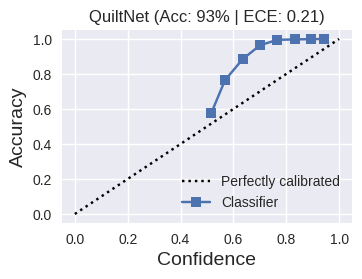

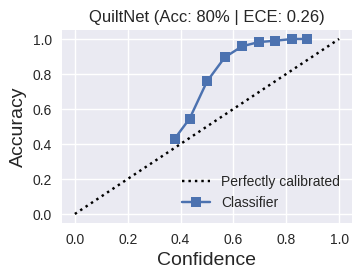

In [ ]:
calibration_display("quilt", "lc25000_colon", None)
calibration_display("quilt", "lc25000_lung", None)

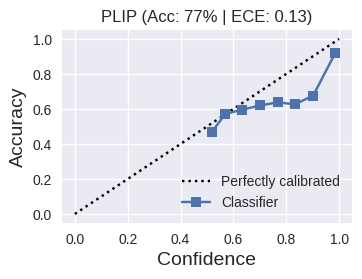

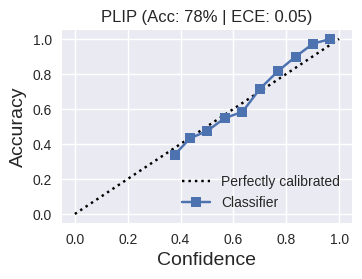

In [ ]:
calibration_display("plip", "lc25000_colon", None)
calibration_display("plip", "lc25000_lung", None)

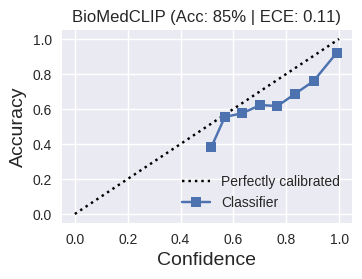

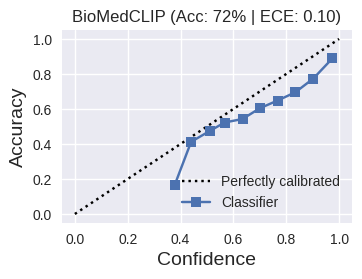

In [ ]:
calibration_display("biomed", "lc25000_colon", None)
calibration_display("biomed", "lc25000_lung", None)

biomed databiox | n data: 872 | acc: 0.34059633027522934 | ece1: 0.6016303671335955 | ece2: 0.6161995375420396
plip databiox | n data: 872 | acc: 0.3795871559633027 | ece1: 0.15200429669487367 | ece2: 0.16171785114717158
quilt databiox | n data: 872 | acc: 0.4048165137614679 | ece1: 0.07835963966512899 | ece2: 0.09467615993818106
biomed sicap | n data: 2122 | acc: 0.3576814326107446 | ece1: 0.4415897305538697 | ece2: 0.46876362785104164
plip sicap | n data: 2122 | acc: 0.44533459000942505 | ece1: 0.11822496566651117 | ece2: 0.12895090436749904
quilt sicap | n data: 2122 | acc: 0.39491046182846373 | ece1: 0.1959562577328291 | ece2: 0.20888483056850843
biomed skin | n data: 28039 | acc: 0.23952352081029993 | ece1: 0.41987724575278224 | ece2: 0.43991957513521845
plip skin | n data: 28039 | acc: 0.3665251970469703 | ece1: 0.10732834994290191 | ece2: 0.1171546940333353
quilt skin | n data: 28039 | acc: 0.45383216234530477 | ece1: 0.14717653277996898 | ece2: 0.16213043270325642
biomed renal_

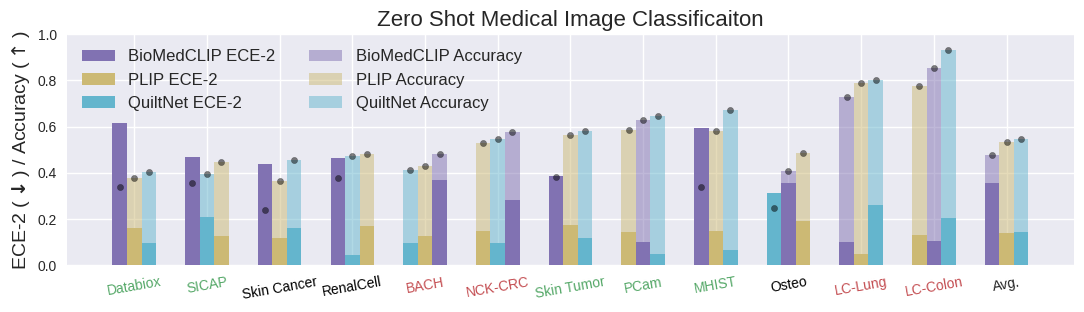

In [ ]:
args = Args(
    metric="ece2",
    descriptors=None
)
run_exp(args)

biomed databiox | n data: 872 | acc: 0.34059633027522934 | ece1: 0.6016303671335955 | ece2: 0.6161995375420396
plip databiox | n data: 872 | acc: 0.3795871559633027 | ece1: 0.15200429669487367 | ece2: 0.16171785114717158
quilt databiox | n data: 872 | acc: 0.4048165137614679 | ece1: 0.07835963966512899 | ece2: 0.09467615993818106
biomed sicap | n data: 2122 | acc: 0.3576814326107446 | ece1: 0.4415897305538697 | ece2: 0.46876362785104164
plip sicap | n data: 2122 | acc: 0.44533459000942505 | ece1: 0.11822496566651117 | ece2: 0.12895090436749904
quilt sicap | n data: 2122 | acc: 0.39491046182846373 | ece1: 0.1959562577328291 | ece2: 0.20888483056850843
biomed skin | n data: 28039 | acc: 0.23952352081029993 | ece1: 0.41987724575278224 | ece2: 0.43991957513521845
plip skin | n data: 28039 | acc: 0.3665251970469703 | ece1: 0.10732834994290191 | ece2: 0.1171546940333353
quilt skin | n data: 28039 | acc: 0.45383216234530477 | ece1: 0.14717653277996898 | ece2: 0.16213043270325642
biomed renal_

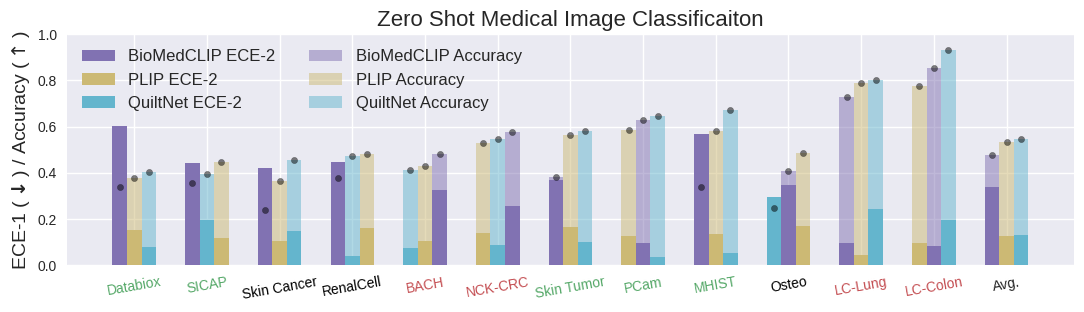

In [ ]:
args = Args(
    metric="ece1",
    descriptors=None
)
run_exp(args)

biomed databiox | n data: 872 | acc: 0.3646788990825688 | ece1: 0.5266939762877214 | ece2: 0.5588734729607735
plip databiox | n data: 872 | acc: 0.3669724770642202 | ece1: 0.2202384140034881 | ece2: 0.23692352452771384
quilt databiox | n data: 872 | acc: 0.38990825688073394 | ece1: 0.10648020312463471 | ece2: 0.1220393616443563
biomed sicap | n data: 2122 | acc: 0.3298774740810556 | ece1: 0.5832914640243947 | ece2: 0.597881950444549
plip sicap | n data: 2122 | acc: 0.35485391140433553 | ece1: 0.23984723100675717 | ece2: 0.2672154187300453
quilt sicap | n data: 2122 | acc: 0.3199811498586239 | ece1: 0.26693442531288175 | ece2: 0.27131962871294113
biomed skin | n data: 28039 | acc: 0.2372053211598131 | ece1: 0.4782810113730735 | ece2: 0.5087127827540802
plip skin | n data: 28039 | acc: 0.3899925104318984 | ece1: 0.16602468308022966 | ece2: 0.17646430069902558
quilt skin | n data: 28039 | acc: 0.4758015621099183 | ece1: 0.11379017999617007 | ece2: 0.12691803830193066
biomed renal_cell | n

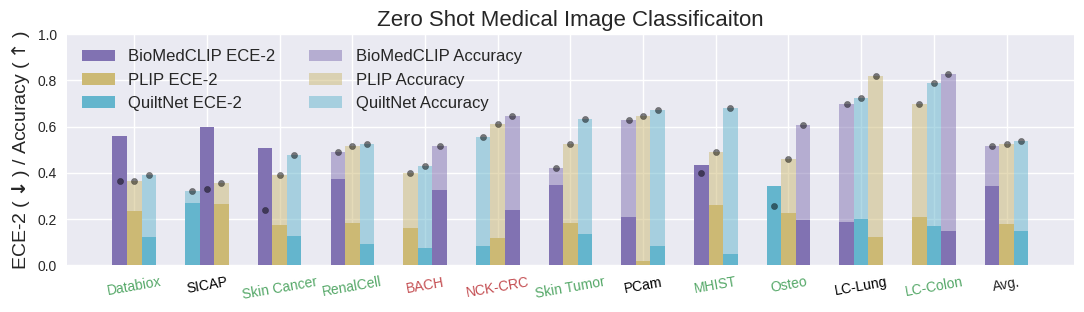

In [ ]:
args = Args(
    metric="ece2",
    descriptors="feature"
)
run_exp(args)

biomed databiox | n data: 872 | acc: 0.3119266055045872 | ece1: 0.5529302216451102 | ece2: 0.5776044697690692
plip databiox | n data: 872 | acc: 0.40825688073394495 | ece1: 0.19621741470940615 | ece2: 0.20891710586561915
quilt databiox | n data: 872 | acc: 0.40940366972477066 | ece1: 0.12906618491498703 | ece2: 0.15965541387834103
biomed sicap | n data: 2122 | acc: 0.3166823751178134 | ece1: 0.5326214983680133 | ece2: 0.5484744837016495
plip sicap | n data: 2122 | acc: 0.4062205466540999 | ece1: 0.20016849640683115 | ece2: 0.22939232793057543
quilt sicap | n data: 2122 | acc: 0.33129123468426014 | ece1: 0.2828869931856267 | ece2: 0.30246814229143787
biomed skin | n data: 28039 | acc: 0.26983843931666607 | ece1: 0.450172813760239 | ece2: 0.4718764269731189
plip skin | n data: 28039 | acc: 0.48432540390170836 | ece1: 0.14467958400901584 | ece2: 0.14621202224890303
quilt skin | n data: 28039 | acc: 0.4554727344056493 | ece1: 0.07665128974553764 | ece2: 0.08569901358042108
biomed renal_cel

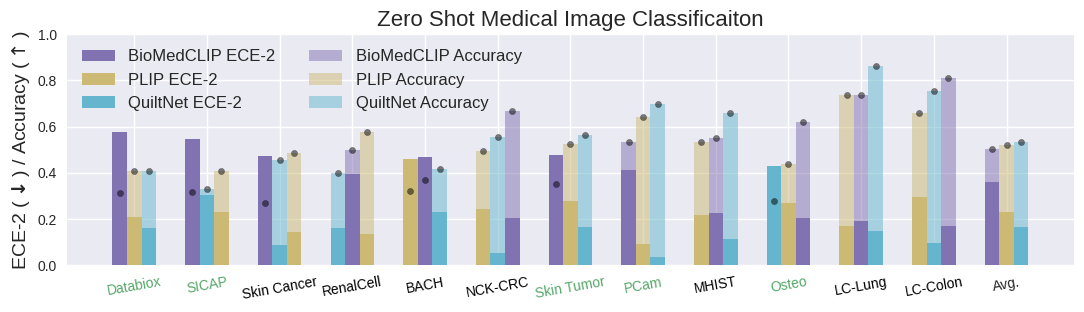

In [ ]:
args = Args(
    metric="ece2",
    descriptors="sentence"
)
run_exp(args)